# Analysis on NASA's Meteorite Landings Dataset

**About Dataset**

    -> This comprehensive data set from The Meteoritical Society contains information on all of the known meteorite landings. The dataset was collected by Javier de la Torre and they have also provided an XLS file that consists of 34,513 meteorites and includes the following fields:

        > name: contains name of meteorite. 

        > id: numeric value given to a particular meteorite.

        > nametype: Under NameType, 'valid' is for most meteorites and 'relict' are for objects that were once meteorites but are now highly altered by weathering on Earth.

        > recclass: contains the type of meteorite based on chemical and physical forms. There are mainly four major categories of meteorites namely "Chondrites", "Achondrites", "Iron Meteorites" and "Other Specialized/Unique Groups".

        > mass(g): contains mass of meteorite in grams.

        > fall: whether a meteorite was found or fell on Earth.

        > year: year when meteorite was found.

        > (reclat,rectlong) or geolocation: gives the geographical location of meteorite.


    This dataset is last updated on January 31, 2023.

In [1]:
"""importing Libraries"""
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import missingno as msno
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from IPython.display import display, clear_output
import plotly.express as px
from sklearn.cluster import KMeans

In [2]:
""" loading dataset"""
mtdata = pd.read_csv("C:/Users/Charanteja/OneDrive/Pictures/Desktop/Other_ReSrcs/Datasets/NASA_Datasets/Meteorite_Landings_20231111.csv")
mtdata.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,"107,000",Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,"1,914",Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


In [3]:
"""Shape of the dataset"""
print(f" Shape of the dataset (rows, col) = ",mtdata.shape)

 Shape of the dataset (rows, col) =  (45716, 10)


# EDA: Exploratory Data Analysis

In [4]:
mtdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  object 
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 3.5+ MB


In [7]:
mtdata['mass (g)'] = mtdata['mass (g)'].str.replace(',', '').astype(float)

In [8]:
del(mtdata['id'])

In [9]:
mtdata.head()

,name,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


In [10]:
"""Checking for null values"""
mtdata.isnull().sum()

name              0
nametype          0
recclass          0
mass (g)        131
fall              0
year            291
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

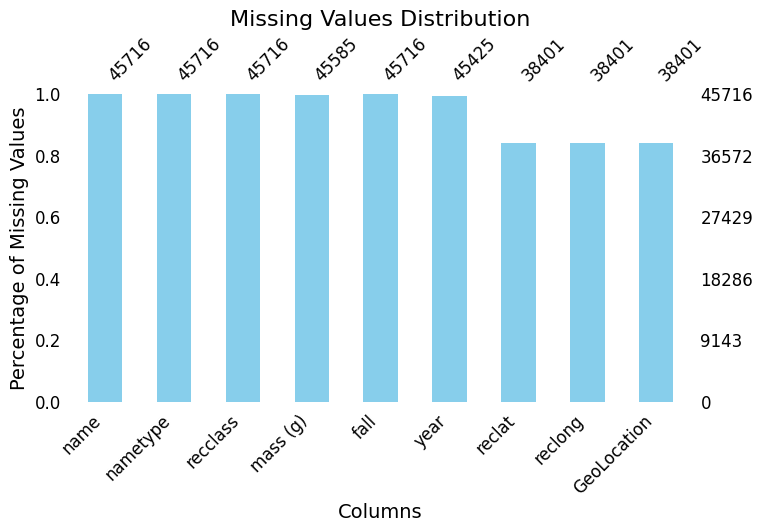

In [11]:
"""Visualization of percentage of null values in each feature"""
fig, ax = plt.subplots(figsize=(8, 4))

msno.bar(mtdata, 
         figsize=(10, 6),        
         color='skyblue',        
         fontsize=12,            
         labels=True,                    
         ax=ax,
         log = False                   
        )

ax.set_title("Missing Values Distribution", fontsize=16)
ax.set_xlabel("Columns", fontsize=14)
ax.set_ylabel("Percentage of Missing Values", fontsize=14)
plt.show()


In [12]:
"""Handling null values for mass feature"""
mtdata["mass (g)"].fillna(mtdata['mass (g)'].mean(),inplace=True)
mtdata["mass (g)"].isnull().sum()

0

In [13]:
"""Handling null values for year feature"""
mtdata.dropna(subset=['year'],inplace=True)
mtdata.shape

(45425, 9)

In [14]:
mtdata_copy = mtdata.copy()
mtdata.dropna(subset=['reclat','reclong','GeoLocation'],inplace=True)

In [15]:
mtdata.isna().sum()

name           0
nametype       0
recclass       0
mass (g)       0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
dtype: int64

In [16]:
"""Checking how many are valid meteorites"""
mtdata.nametype.value_counts()

nametype
Valid     38154
Relict       69
Name: count, dtype: int64

-> Out of 45716 total objects, 45641 are meteorites and 75 are objects that are altered by weathering on Earth.

In [17]:
"""Count of meteorites that found and fell on the earth"""
mtdata.fall.value_counts()

fall
Found    37126
Fell      1097
Name: count, dtype: int64

In [18]:
"""Different types of classes of meteorites"""
class_len = len(mtdata.recclass.unique())
print(f"Number different classes of meteorites =",class_len)

Number different classes of meteorites = 424


In [19]:
"""Most frequently found/fell meteorite class(es)"""
freq_c = mtdata.recclass.value_counts()
most_comm_classes = freq_c.sort_values(ascending=False)[:10]
print(f"Top 10 most found/fell meteorite classes are :\n",most_comm_classes)

Top 10 most found/fell meteorite classes are :
 recclass
L6      7525
H5      6247
H6      3898
H4      3880
L5      3266
LL5     2199
LL6     1660
L4       939
H4/5     395
CM2      332
Name: count, dtype: int64


In [20]:
"""meteorite having maximum/minimum/average mass, category of class it belongs, whether it was found/fell and year"""
max_mass_val = mtdata['mass (g)'].max()
max_ind = mtdata['mass (g)'].argmax()
print("'{}' meteorite having maximum mass of '{}g' was '{}' on Earth in '{}'".format(mtdata['name'][max_ind],max_mass_val,mtdata['fall'][max_ind],int(mtdata['year'][max_ind])))
min_mass_val = mtdata['mass (g)'].min()
min_ind = mtdata['mass (g)'].argmin()
print("'{}' meteorite having minimum mass of '{}g' was '{}' on Earth in '{}'".format(mtdata['name'][min_ind],min_mass_val,mtdata['fall'][min_ind],int(mtdata['year'][min_ind])))

'Grove Mountains 054230' meteorite having maximum mass of '60000000.0g' was 'Found' on Earth in '2006'
'Frontier Mountain 90212' meteorite having minimum mass of '0.0g' was 'Found' on Earth in '1990'


In [21]:
"""Description of metorite that belongs to 'L6' class based on their mass"""
mtdata[mtdata['recclass']=='L6']['mass (g)'].describe()

count      7525.000000
mean       1525.558215
std       14637.195331
min           0.030000
25%           7.430000
50%          33.020000
75%         191.700000
max      564000.000000
Name: mass (g), dtype: float64

**Insights that can be drawn from this dataset are:**

**1. Spatial Distribution:**

        -> Identify regions with a higher concentration of meteorite falls or finds based on geographical coordinates (longitude and latitude).
        -> Visualize the spatial distribution of meteorites on a map to observe any clustering or patterns.

**2. Temporal Trends:**

        -> Analyze the distribution of meteorites over the years to identify any temporal trends or patterns.
        -> Explore whether there are specific years with a higher occurrence of meteorite falls or finds.

**3. Meteorite Types:**

        -> Explore the different types of meteorites in the dataset and their frequency.
        -> Analyze whether certain types of meteorites are more likely to fall in specific regions.

**4. Fell vs. Found:**

        -> Compare the number of meteorites that were observed falling (fell) to those that were discovered later (found).
        -> Investigate if there are differences in the characteristics of fallen and found meteorites.

**5. Mass Distribution:**

        -> Examine the distribution of meteorite masses to understand the range and common mass values.
        -> Identify any correlation between the type of meteorite and its mass.

**6. Coordinate Analysis:**

        -> Investigate if there are any correlations between meteorite characteristics and specific geographical coordinates.
        -> Use clustering algorithms to identify regions with similar meteorite characteristics.

# Spatial Distribution

C:\Users\Charanteja\AppData\Local\Temp\ipykernel_9108\3407161156.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


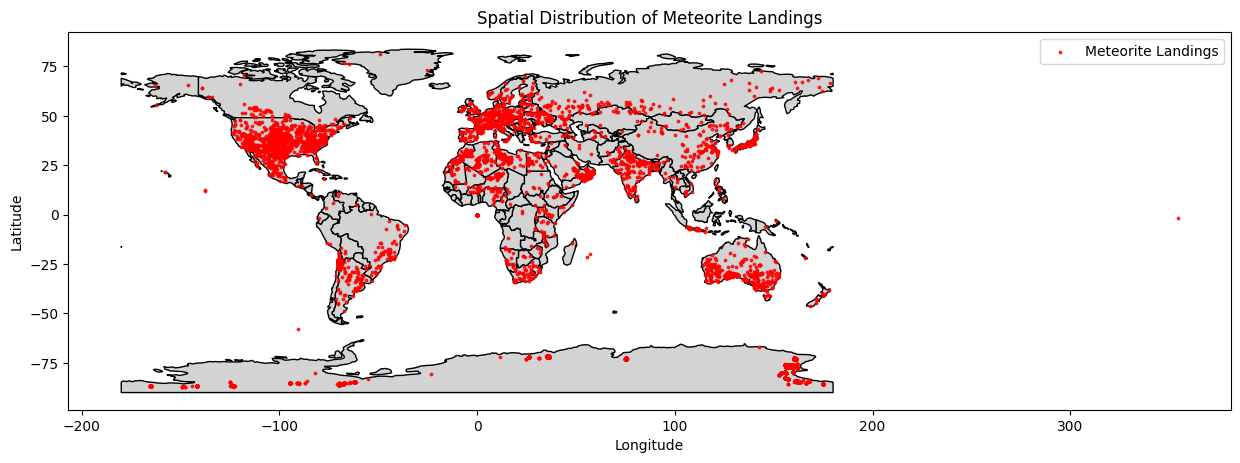

In [22]:
"Create a GeoDataFrame"
gdf = gpd.GeoDataFrame(mtdata, geometry=gpd.points_from_xy(mtdata['reclong'], mtdata['reclat']))

"Plot the spatial distribution on a world map"
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 10), color='lightgrey', edgecolor='black')

gdf.plot(ax=ax, color='red', markersize=3, alpha=0.8, label='Meteorite Landings')

"Add labels and title"
plt.title('Spatial Distribution of Meteorite Landings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()
plt.show()

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Charanteja\AppData\Local\Temp\ipykernel_9108\3276537744.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


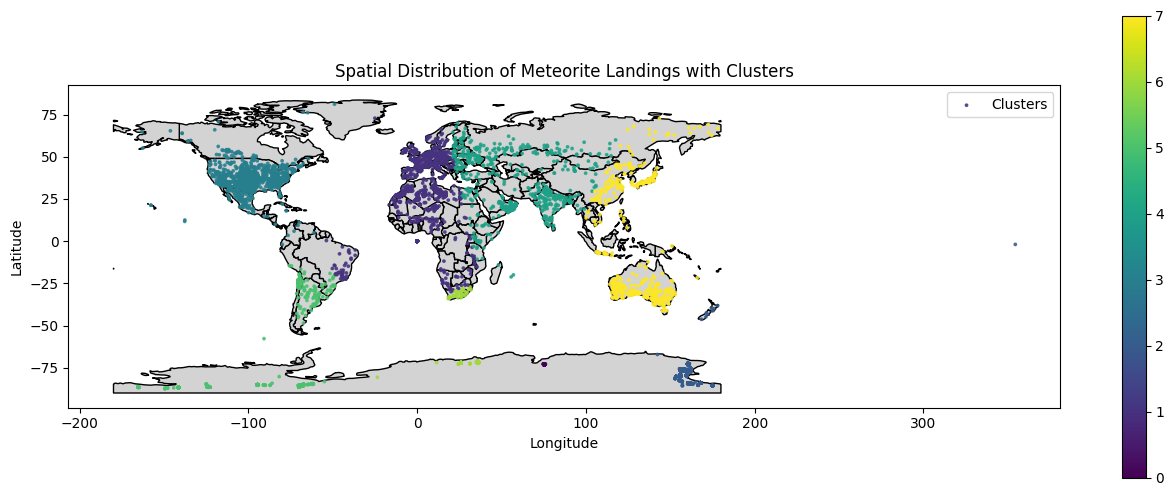

In [23]:
# Assuming 'mtdata' is your DataFrame with latitude and longitude columns
gdf = gpd.GeoDataFrame(mtdata, geometry=gpd.points_from_xy(mtdata['reclong'], mtdata['reclat']))

# Select relevant features for clustering
selected_features = gdf[['reclat', 'reclong']]

# KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(selected_features)
gdf['cluster'] = kmeans.labels_

# Plot the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(16, 6), color='lightgrey', edgecolor='black')

# Plot clustered points
gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=3, alpha=0.8, legend=True, label='Clusters')

# Add labels and title
plt.title('Spatial Distribution of Meteorite Landings with Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()
plt.show()

**Observations**

    -> The world map provides context for the distribution of meteorite landings across the globe.
    -> The plotted points represent meteorite landing locations.
    -> The colors represent different clusters identified by the KMeans algorithm based on the spatial proximity of meteorite landings.
    -> Clusters could indicate regions or areas where meteorites have landed in spatially close proximity.
    -> This visualization helps in understanding the spatial distribution of meteorite landings and how they are grouped or clustered based on their  geographic proximity.

In [ ]:
cord = list(zip(mtdata['reclat'],mtdata['reclong']))
geolocator = Nominatim(user_agent="my_geocoder")

location_names = []
for lat, lon in cord:
    location = geolocator.reverse((lat, lon), language='en')
    if location is not None:
        location_names.append(location.address)
    else:
        location_names.append("Unknown")

print(location_names)

In [24]:
mtdata['reclong'].isna().sum()

0

# Temporal Trends

In [27]:
meteorites_by_year = mtdata.groupby('year').size().reset_index(name='count')
meteorites_by_year = meteorites_by_year[:len(meteorites_by_year)-1]
meteorites_by_year

,year,count
0,860.0,1
1,920.0,1
2,1399.0,1
3,1490.0,1
4,1491.0,1
...,...,...
259,2009.0,1496
260,2010.0,1005
261,2011.0,713
262,2012.0,234


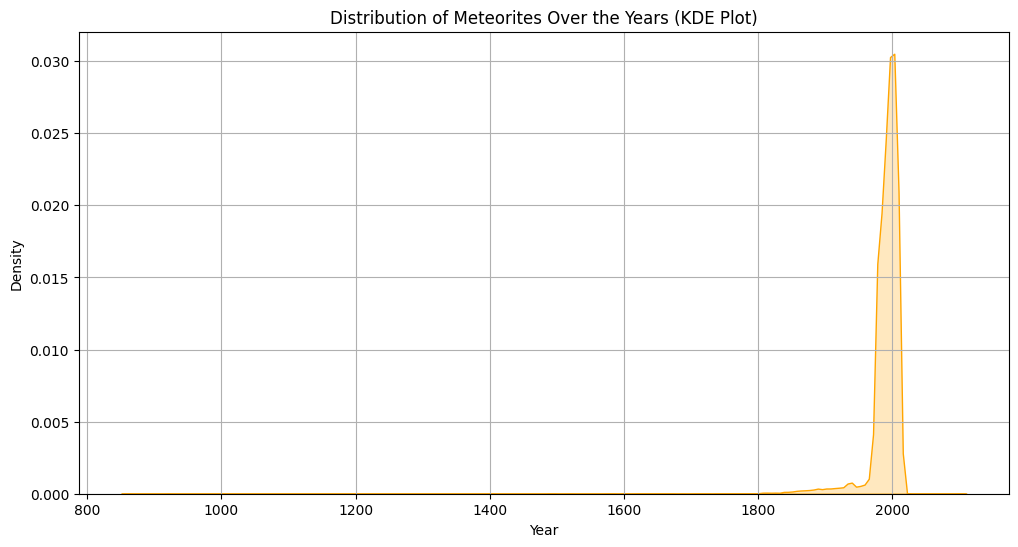

In [107]:
plt.figure(figsize=(12, 6))
sns.kdeplot(mtdata['year'], fill=True, color='orange')
plt.title('Distribution of Meteorites Over the Years (KDE Plot)')
plt.xlabel('Year')
plt.ylabel('Density')
plt.grid(True)
plt.show()


**Observations**

    ->

# Meteorite Types

In [127]:
"""Top 20 most occurred classes of meteorites"""
top_n = 20 
top_classes = mtdata['recclass'].value_counts().head(top_n)
top_classes

recclass
L6             7525
H5             6247
H6             3898
H4             3880
L5             3266
LL5            2199
LL6            1660
L4              939
H4/5            395
CM2             332
H3              313
CO3             308
Iron, IIIAB     270
L3              268
LL              223
Ureilite        214
E3              205
LL4             198
CV3             184
Howardite       179
Name: count, dtype: int64

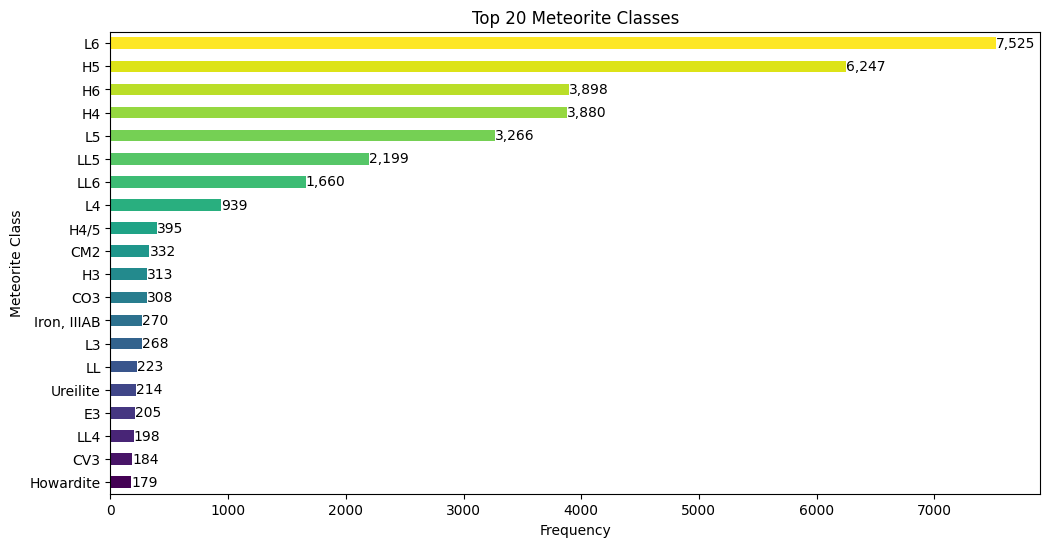

In [129]:
"""visualizing the top 20 classes and their counts"""
top_classes = mtdata['recclass'].value_counts().head(top_n)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_classes)))
plt.figure(figsize=(12, 6))
# top_classes.sort_values().plot(kind='barh', color='skyblue')
bars = top_classes.sort_values().plot(kind='barh', color=colors)
for bar in bars.patches:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():,.0f}', ha='left', va='center')
plt.title(f'Top {top_n} Meteorite Classes')
plt.xlabel('Frequency')
plt.ylabel('Meteorite Class')
plt.show()


**Observations**

    ->

In [35]:
len(mtdata['recclass'].unique())

424

In [41]:
def group_meteorites(meteorite_classes):
    groups = {
        'Chondrites': [],
        'Achondrites': [],
        'Iron Meteorites': [],
        'Other Specialized/Unique Groups': []
    }

    for meteorite_class in meteorite_classes:
        if 'LL' in meteorite_class or 'H' in meteorite_class or 'L' in meteorite_class:
            groups['Chondrites'].append(meteorite_class)
        elif 'E' in meteorite_class or 'achondrite' in meteorite_class or 'enst' in meteorite_class:
            groups['Achondrites'].append(meteorite_class)
        elif 'Iron' in meteorite_class or 'IVA' in meteorite_class or 'IIAB' in meteorite_class:
            groups['Iron Meteorites'].append(meteorite_class)
        else:
            groups['Other Specialized/Unique Groups'].append(meteorite_class)

    return groups

grouped_meteorites = group_meteorites(mtdata['recclass'])
for group, classes in grouped_meteorites.items():
    print(f"{group}: {len(classes)}")


Chondrites: 34153
Achondrites: 756
Iron Meteorites: 892
Other Specialized/Unique Groups: 2422


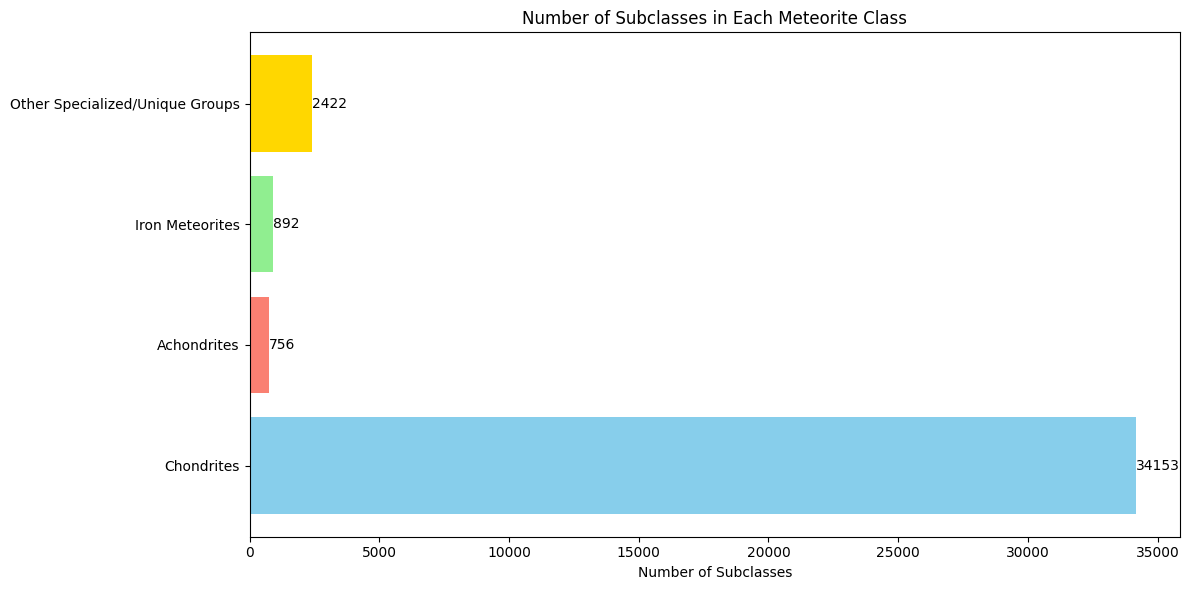

In [49]:

def visualize_classes(grouped_meteorites):
    classes = list(grouped_meteorites.keys())
    subclass_counts = [len(subclasses) for subclasses in grouped_meteorites.values()]
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'palegreen', 'lightpink', 'lightsalmon', 'lightseagreen']
    plt.figure(figsize=(12, 6))
    plt.barh(classes, subclass_counts, color=colors)
    plt.xlabel('Number of Subclasses')
    plt.title('Number of Subclasses in Each Meteorite Class')
    for index, value in enumerate(subclass_counts):
        plt.text(value, index, str(value), ha='left', va='center')
    plt.tight_layout()
    plt.show()


meteorite_classes = mtdata['recclass']

grouped_meteorites = group_meteorites(meteorite_classes)

# Visualize classes and subclasses
visualize_classes(grouped_meteorites)


# Fell vs Found

C:\Users\Charanteja\AppData\Local\Temp\ipykernel_20448\289012117.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=fall_vs_found.index, y=fall_vs_found.values, palette='viridis')


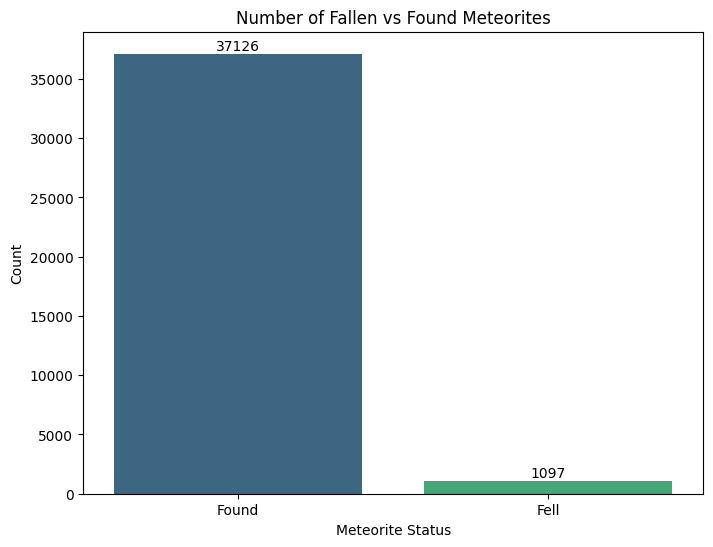

In [136]:

fall_vs_found = mtdata['fall'].value_counts()

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=fall_vs_found.index, y=fall_vs_found.values, palette='viridis')
plt.title('Number of Fallen vs Found Meteorites')
plt.xlabel('Meteorite Status')
plt.ylabel('Count')
for index, value in enumerate(fall_vs_found.values):
    bar_plot.text(index, value + 0.1, str(value), ha='center', va='bottom')
plt.show()


C:\Users\Charanteja\AppData\Local\Temp\ipykernel_20448\2858051497.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='fall', y='mass (g)', data=mtdata, palette='Set2')


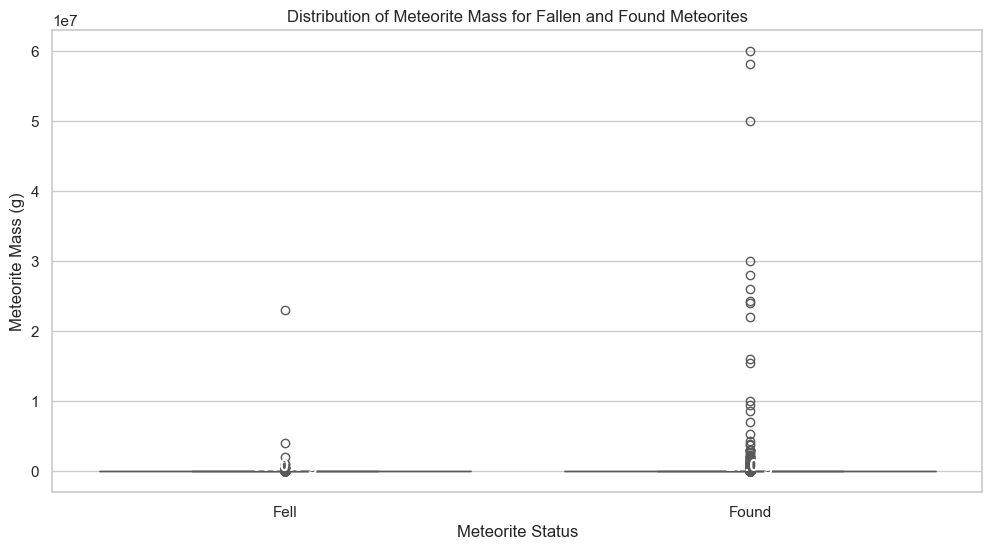

In [138]:
# Assuming your DataFrame is named 'df'
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
boxplot = sns.boxplot(x='fall', y='mass (g)', data=mtdata, palette='Set2')
plt.title('Distribution of Meteorite Mass for Fallen and Found Meteorites')
plt.xlabel('Meteorite Status')
plt.ylabel('Meteorite Mass (g)')

# Adding annotations
medians = mtdata.groupby('fall')['mass (g)'].median().values
median_labels = [f'{round(median, 2)} g' for median in medians]

pos = range(len(medians))
for tick, label in zip(pos, boxplot.get_xticklabels()):
    boxplot.text(pos[tick], medians[tick] + 0.01, median_labels[tick],
                 horizontalalignment='center', color='w', weight='bold')

plt.show()

**Observations**

    ->

In [139]:
from scipy.stats import ttest_ind

fallen_mass = mtdata[mtdata['fall'] == 'Fell']['mass (g)'].dropna()
found_mass = mtdata[mtdata['fall'] == 'Found']['mass (g)'].dropna()

t_stat, p_value = ttest_ind(fallen_mass, found_mass, equal_var=False)

print(f'T-test results - t-statistic: {t_stat}, p-value: {p_value}')


T-test results - t-statistic: 1.4683012377376163, p-value: 0.14229663597258943


# Coordinate Analysis

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

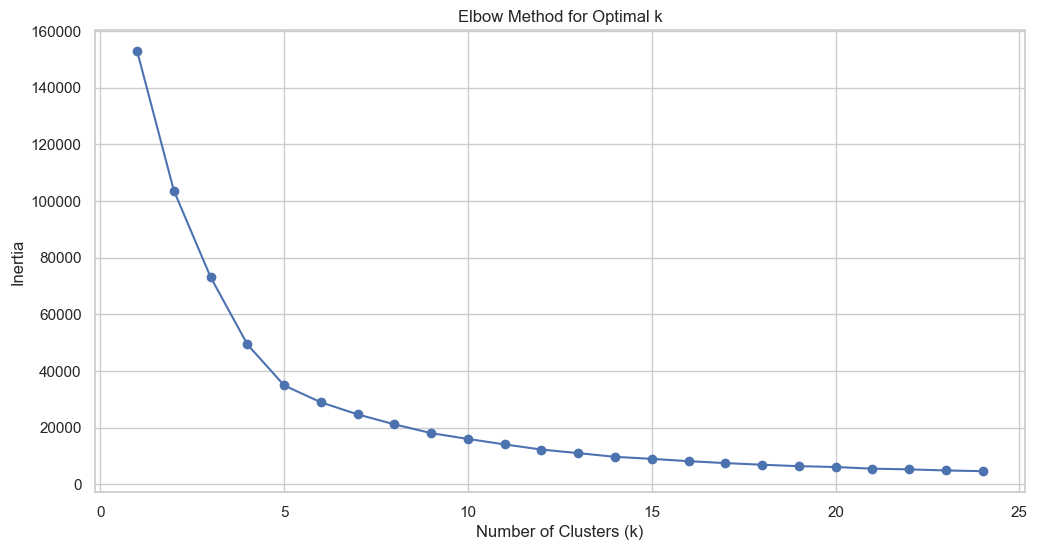

In [178]:
# Assuming 'df' is your DataFrame with relevant features
selected_features = mtdata[['mass (g)', 'year', 'reclat', 'reclong']]

# Data normalization
selected_features_normalized = (selected_features - selected_features.mean()) / selected_features.std()

# Elbow method to find the optimal k
inertia_values = []
k_values = range(1, 25)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_features_normalized)
    inertia_values.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(12,6))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

**Observations**

    ->

c:\Users\Charanteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



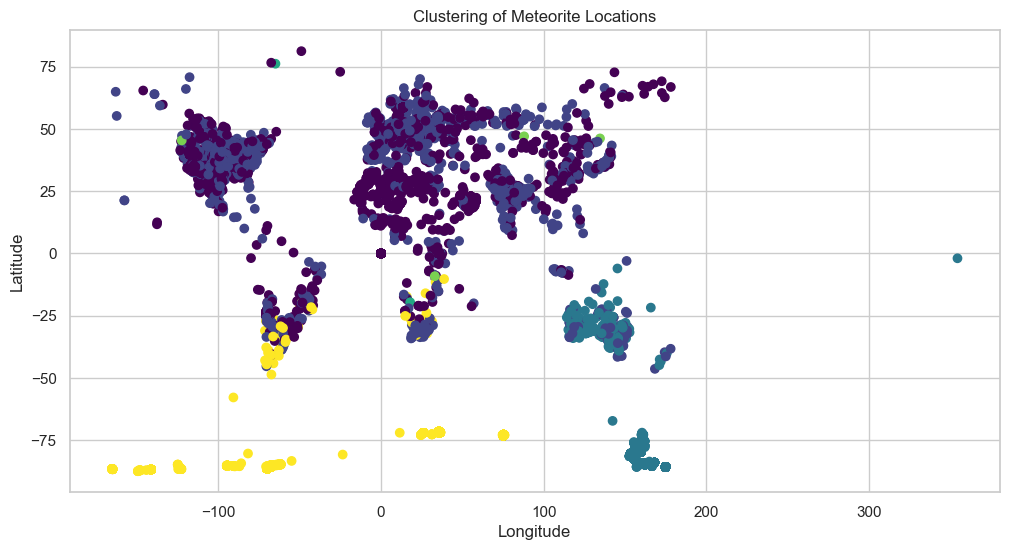

In [179]:

# Assuming 'df' is your DataFrame with relevant features
selected_features = mtdata[['mass (g)', 'year', 'reclat', 'reclong']]

# Data normalization
selected_features_normalized = (selected_features - selected_features.mean()) / selected_features.std()

# KMeans clustering
kmeans = KMeans(n_clusters=6)  # You can choose the number of clusters
kmeans.fit(selected_features_normalized)

# Add cluster labels to the DataFrame
mtdata['cluster'] = kmeans.labels_

# Visualize clusters on a map
plt.figure(figsize=(12,6))
plt.scatter(mtdata['reclong'], mtdata['reclat'], c=mtdata['cluster'], cmap='viridis')
plt.title('Clustering of Meteorite Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


**Observations**

    ->

In [164]:

import folium
from folium.plugins import MarkerCluster

gdf = gpd.GeoDataFrame(mtdata, geometry=gpd.points_from_xy(mtdata['reclong'], mtdata['reclat']))

# Create a GeoJSON file from the GeoDataFrame
gdf.to_file("meteorite_clusters.geojson", driver="GeoJSON")

# Create a folium map centered around the mean latitude and longitude
m = folium.Map(location=[mtdata['reclat'].mean(), mtdata['reclong'].mean()], zoom_start=2)

# Add a MarkerCluster layer
marker_cluster = MarkerCluster().add_to(m)

# Add each point to the MarkerCluster layer
for idx, row in gdf.iterrows():
    folium.Marker([row['reclat'], row['reclong']], popup=f"Cluster: {row['cluster']}").add_to(marker_cluster)

# Save the map
m.save("meteorite_clusters_map.html")
